In [11]:
import pandas as pd
import numpy as np
from rdkit.Chem import MolFromSmiles, AllChem, MolToSmiles
from rdkit import DataStructs

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
%matplotlib inline

def generate_fingerprints(smile):
    mol = MolFromSmiles(smile)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=1024)
#     fp = AllChem.GetMorganFingerprint(mol, radius=3)
    return fp

def fp_to_numpy(fp):
    array = np.zeros((0,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, array)
#     print(array)
    return array

def read_df(path, reg=False, threshold=3):
    df = pd.read_csv(path)
    df['IC50'] = df['IC50'].astype(str)
    for i, row in df.iterrows():
        if '>' in row['IC50']:
            df.loc[i, 'class'] = False
        elif float(row['IC50']) > threshold:
            df.loc[i, 'class'] = False
        else:
            df.loc[i, 'class'] = True
    y = df['class'].astype('int').to_numpy()
        
    if reg:
        df = df[~df['IC50'].astype(str).str.contains('>')]
        df = df[df['IC50'].notnull()]
        df['IC50'] = df['IC50'].astype(float)
        df = df[df['IC50']<90]
        y = -np.log10(df['IC50'].to_numpy()) + 6
#         y = df['IC50'].to_numpy()
    # TODO classification
        
    x_morgan = [generate_fingerprints(smi) for smi in df['SMILES']]
    inds = df.index.values
    return df, x_morgan, y, inds
    
reg = True    
threshold = 3

df1, x1_morgan, y1, inds_1 = read_df('combined_acid.csv', reg=True, threshold=threshold)
df2, x2_morgan, y2, inds_2 = read_df('combined_aldehyde.csv', reg=True, threshold=threshold)
df3, x3_morgan, y3, inds_3 = read_df('combined_amine.csv', reg=True, threshold=threshold)
df4, x4_morgan, y4, inds_4 = read_df('combined_isocyanide.csv', reg=True, threshold=threshold)

df1, x1_morgan_class, y1_class, inds_1_class = read_df('combined_acid.csv', reg=False, threshold=threshold)
df2, x2_morgan_class, y2_class, inds_2_class = read_df('combined_aldehyde.csv', reg=False, threshold=threshold)
df3, x3_morgan_class, y3_class, inds_3_class = read_df('combined_amine.csv', reg=False, threshold=threshold)
df4, x4_morgan_class, y4_class, inds_4_class = read_df('combined_isocyanide.csv', reg=False, threshold=threshold)

df_train = pd.concat([df1, df2, df3, df4])

xs_morgan = [x1_morgan, x2_morgan, x3_morgan, x4_morgan]
ys = [y1, y2, y3, y4]

x1 = np.load('acid_fps.npy')[inds_1]
x2 = np.load('ald_fps.npy')[inds_2]
x3 = np.load('amine_fps.npy')[inds_3]
x4 = np.load('iso_fps.npy')[inds_4]
xs_fp = [x1, x2, x3, x4]

xs_morgan_class = [x1_morgan_class, x2_morgan_class, x3_morgan_class, x4_morgan_class]
ys_class = [y1_class, y2_class, y3_class, y4_class]

x1_class = np.load('acid_fps.npy')[inds_1_class]
x2_class = np.load('ald_fps.npy')[inds_2_class]
x3_class = np.load('amine_fps.npy')[inds_3_class]
x4_class = np.load('iso_fps.npy')[inds_4_class]
xs_fp_class = [x1_class, x2_class, x3_class, x4_class]


In [2]:
print(df1)
print(y1)

                                               SMILES    IC50  Unnamed: 2  \
0   CC(C)(C)c1ccc(cc1)N(C(C(=O)NCCc1cccc(F)c1)c1cc...    8.41         NaN   
1   CC(C)(C)c1ccc(cc1)N(C(C(=O)NCCc1cccc(F)c1)c1cc...    13.2         NaN   
2   CC(C)(C)c1ccc(cc1)N(C(C(=O)NCCc1cccc(F)c1)c1cc...   0.891         NaN   
3   CC(C)(C)c1ccc(cc1)N(C(C(=O)NCCc1cccc(F)c1)c1cc...  > 99.5         NaN   
4   CC(C)(C)c1ccc(cc1)N(C(C(=O)NCCc1cccc(F)c1)c1cc...    1.11         NaN   
..                                                ...     ...         ...   
92  CC(C)(C)c1ccc(cc1)N(C(C(=O)NCCc1cccc(F)c1)c1cc...    2.53         NaN   
93  CC(C)(C)c1ccc(cc1)N(C(C(=O)NCCc1cccc(F)c1)c1cn...    7.48         NaN   
94  Cc1cncc(c1)C(N(C(=O)C=C)c1ccc(cc1)C(C)(C)C)C(=...    11.6         NaN   
95  CC(C)(C)c1ccc(cc1)N(C(C(=O)NCCc1cccc(F)c1)c1cn...    11.5         NaN   
96  CC(C)(C)c1ccc(cc1)N(C(C(=O)NCCc1cccc(F)c1)c1cc...    2.96         NaN   

    Unnamed: 3  Unnamed: 4  class  
0          NaN         NaN  False  
1  

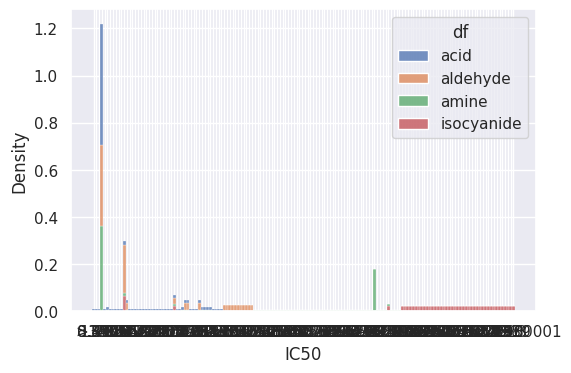

In [2]:
sns.set(rc={"figure.dpi":100})

names = ['acid', 'aldehyde', 'amine', 'isocyanide']
df_all = [df1, df2, df3, df4]
for i,df in enumerate(df_all):
    df['df'] = names[i]

df_all = pd.concat(df_all)
sns.histplot(data = df_all, x="IC50", hue="df", stat='density', common_norm=False, multiple="stack")
# sns.displot(data = df_all, x="class", hue="df", multiple="stack")
# plt.legend()
# plt.show()

In [12]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import auc, roc_auc_score, precision_recall_curve
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

def rand_fit_forest(X,y, reg=False):
#     params = {'n_estimators': [100, 1000, 10000], 'max_depth': [1, 2, 3], 'min_samples_split': [2, 4]}
    
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(1, 110, num = 12)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    
    params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
#     params = {'n_estimators': [1000], 'max_depth': [1, 2]}
    if reg:
        search = RandomizedSearchCV(RandomForestRegressor(), params, n_iter=50, n_jobs=-1, cv=5, verbose=1)
    else:
        search = RandomizedSearchCV(RandomForestClassifier(), params, n_iter=50, n_jobs=-1, cv=5, verbose=1)
    model  = search.fit(X, y).best_estimator_
    print(search.best_params_)
    return model


def grid_fit_forest(X,y):
#     params = {'n_estimators': [100, 1000, 10000], 'max_depth': [1, 2, 3], 'min_samples_split': [2, 4]}
    
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 500, stop = 2000, num = 10)]
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(50, 100, num = 6)]
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [4, 6, 8]
    
    params = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
#     params = {'n_estimators': [1000], 'max_depth': [1, 2]}
    search = GridSearchCV(RandomForestClassifier(bootstrap=False), params, n_iter=100, n_jobs=-1, cv=5, verbose=2)
    model  = search.fit(X, y).best_estimator_
    print(search.best_params_)
    return model

In [13]:
def enrichment(preds, targets, n=10, log=False):

    orig_prop = np.sum(targets)/len(targets)
    if log:
        print('orig proportion: {:.3f}%'.format(orig_prop*100))
        
    inds = np.argpartition(preds, -n)[-n:]
    subset = targets[inds]
    new_prop = np.sum(subset)/len(subset)
    if log:
        print('N = {}, n_hits = {}, new proportion of: {:.3f}%'.format(n, len(sorted_df[sorted_df[index]]), new_prop*100))
    EF = new_prop/orig_prop
    return EF

MPNN FPs:
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   19.4s finished
/rds-d2/user/wjm41/hpc-work/conda/envs/dgl_life/lib/python3.6/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': False}
Morgan FPs:
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   17.6s finished
/rds-d2/user/wjm41/hpc-work/conda/envs/dgl_life/lib/python3.6/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'n_estimators': 1800, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 110, 'bootstrap': False}

Training Set (n = 120):
RF MPNN FPs:
R2: 0.886
RMSE: 0.251
GP MPNN FPs:
R2: 0.915
RMSE: 0.217
RF Morgan FPs:
R2: 0.832
RMSE: 0.304
RF MPNN FPs:
roc: 0.500
prc: 0.601
GPR MPNN FPs:
roc: 0.500
prc: 0.601
RF Morgan FPs:
roc: 0.500
prc: 0.601

Test Set (acid):
RF MPNN FPs:
R2: 0.426
RMSE: 0.593
GP MPNN FPs:
R2: 0.268
RMSE: 0.669
RF Morgan FPs:
R2: 0.150
RMSE: 0.721


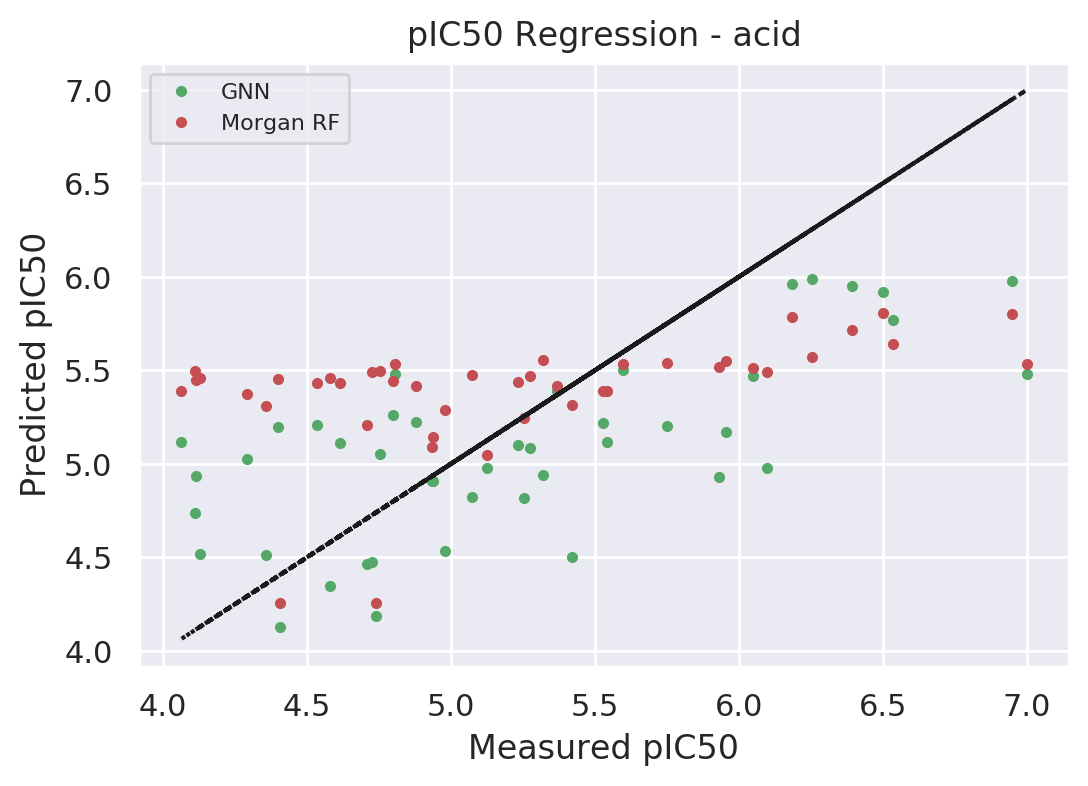

RF MPNN FPs:
roc: 0.676
prc: 0.733
GP MPNN FPs:
roc: 0.676
prc: 0.733
RF Morgan FPs:
roc: 0.757
prc: 0.643


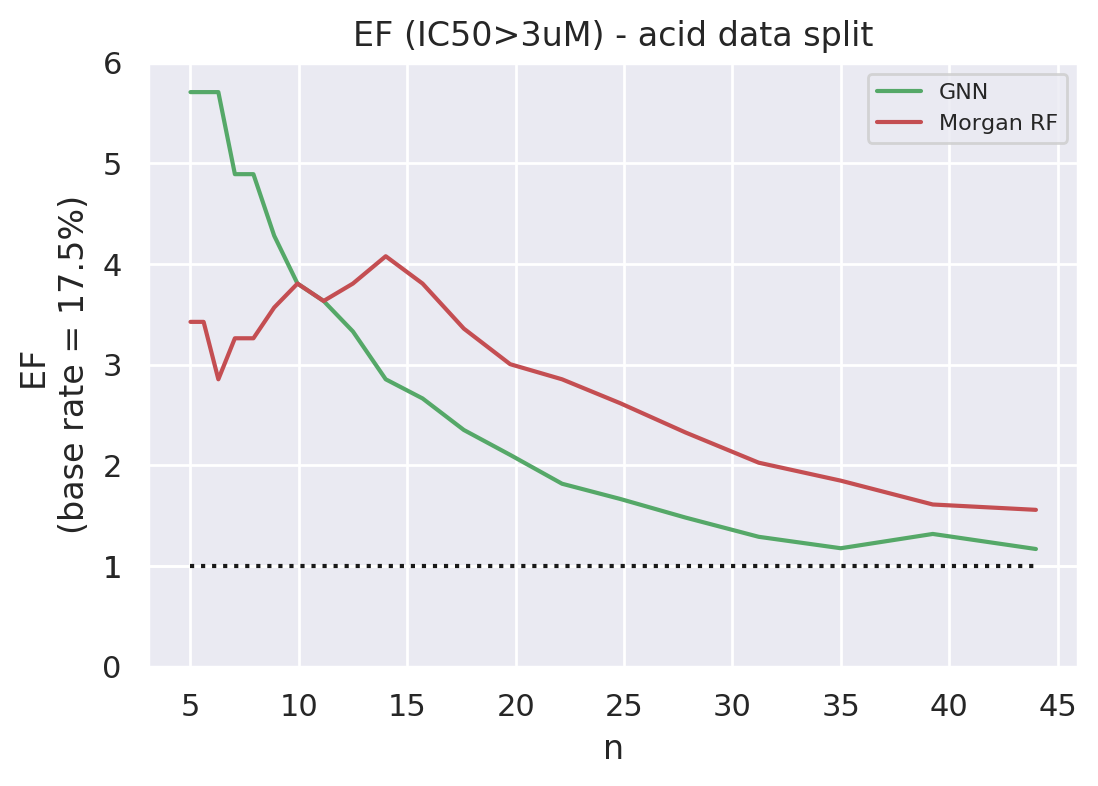

MPNN FPs:
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   25.1s finished
/rds-d2/user/wjm41/hpc-work/conda/envs/dgl_life/lib/python3.6/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 80, 'bootstrap': False}
Morgan FPs:
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   21.8s finished
/rds-d2/user/wjm41/hpc-work/conda/envs/dgl_life/lib/python3.6/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': True}

Training Set (n = 149):
RF MPNN FPs:
R2: 0.852
RMSE: 0.290
GP MPNN FPs:
R2: 0.880
RMSE: 0.261
RF Morgan FPs:
R2: 0.815
RMSE: 0.324
RF MPNN FPs:
roc: 0.500
prc: 0.577
GPR MPNN FPs:
roc: 0.500
prc: 0.577
RF Morgan FPs:
roc: 0.500
prc: 0.577

Test Set (aldehyde):
RF MPNN FPs:
R2: -0.315
RMSE: 0.833
GP MPNN FPs:
R2: -0.415
RMSE: 0.864
RF Morgan FPs:
R2: 0.193
RMSE: 0.653


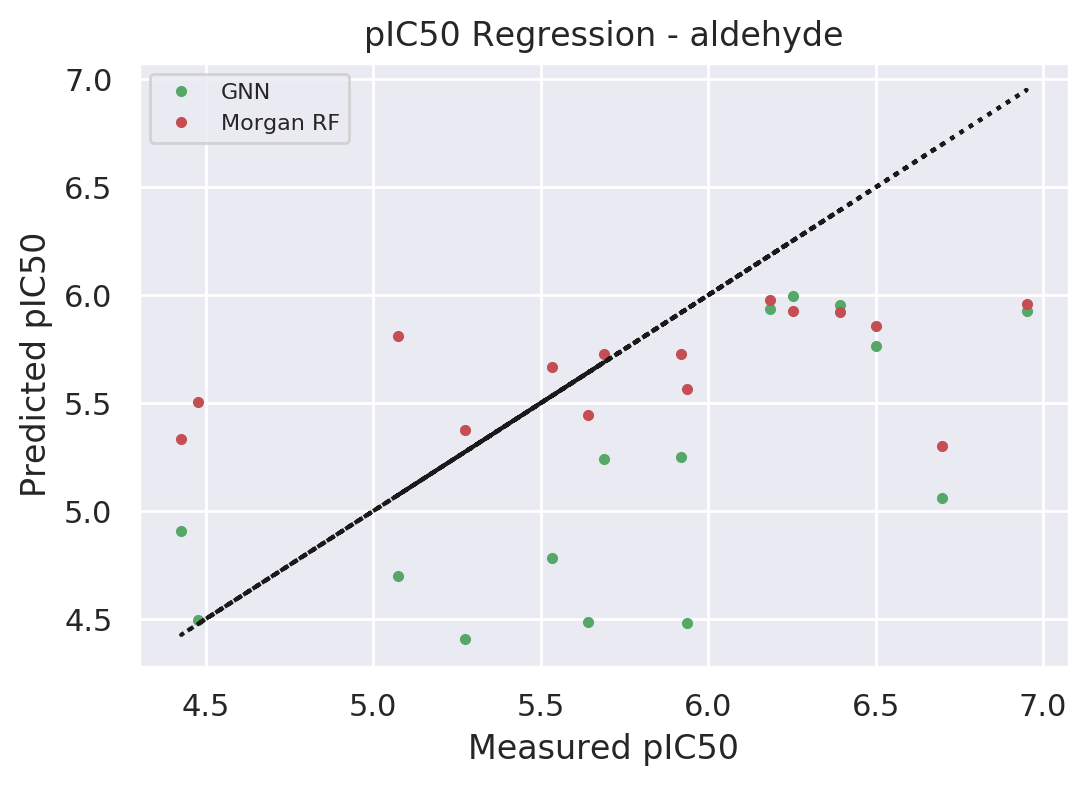

RF MPNN FPs:
roc: 0.639
prc: 0.825
GP MPNN FPs:
roc: 0.639
prc: 0.825
RF Morgan FPs:
roc: 0.711
prc: 0.800


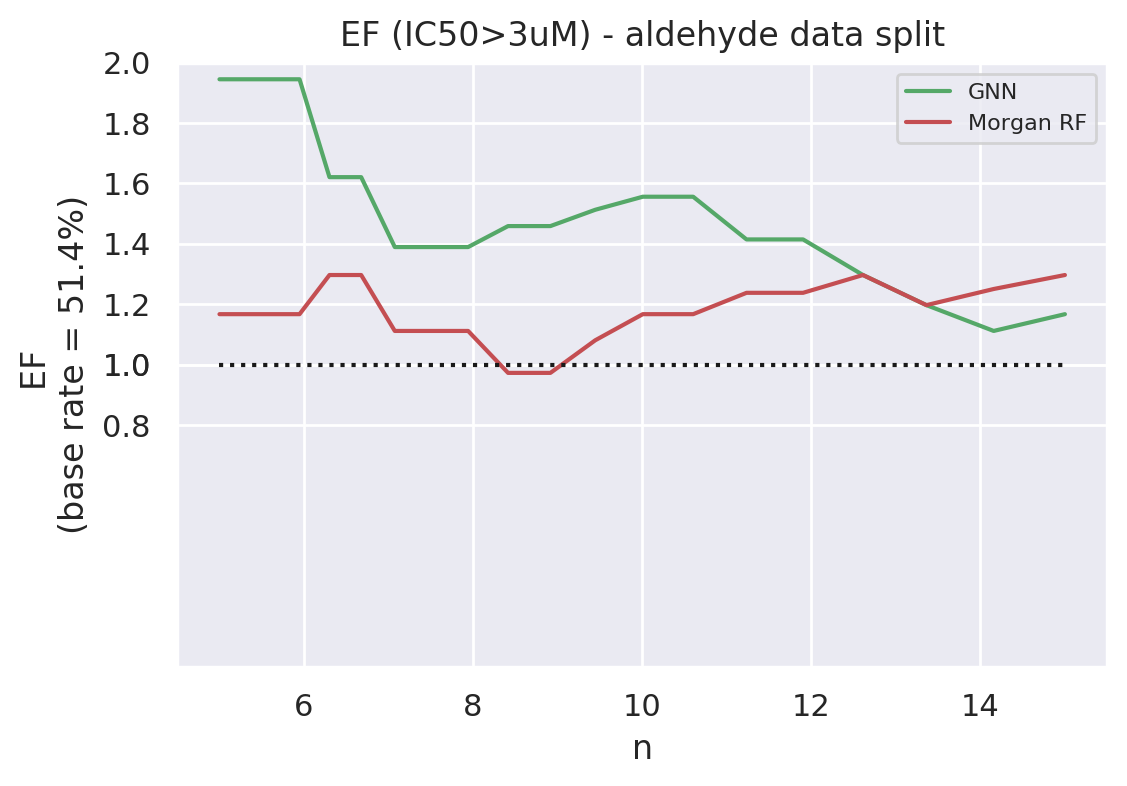

MPNN FPs:
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   17.7s finished
/rds-d2/user/wjm41/hpc-work/conda/envs/dgl_life/lib/python3.6/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'n_estimators': 2000, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': False}
Morgan FPs:
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:   15.8s finished
/rds-d2/user/wjm41/hpc-work/conda/envs/dgl_life/lib/python3.6/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'n_estimators': 1400, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 110, 'bootstrap': False}

Training Set (n = 102):
RF MPNN FPs:
R2: 0.824
RMSE: 0.296
GP MPNN FPs:
R2: 0.879
RMSE: 0.246
RF Morgan FPs:
R2: 0.730
RMSE: 0.367
RF MPNN FPs:
roc: 0.500
prc: 0.632
GPR MPNN FPs:
roc: 0.500
prc: 0.632
RF Morgan FPs:
roc: 0.500
prc: 0.632

Test Set (amine):
RF MPNN FPs:
R2: 0.370
RMSE: 0.644
GP MPNN FPs:
R2: 0.399
RMSE: 0.629
RF Morgan FPs:
R2: -0.341
RMSE: 0.940


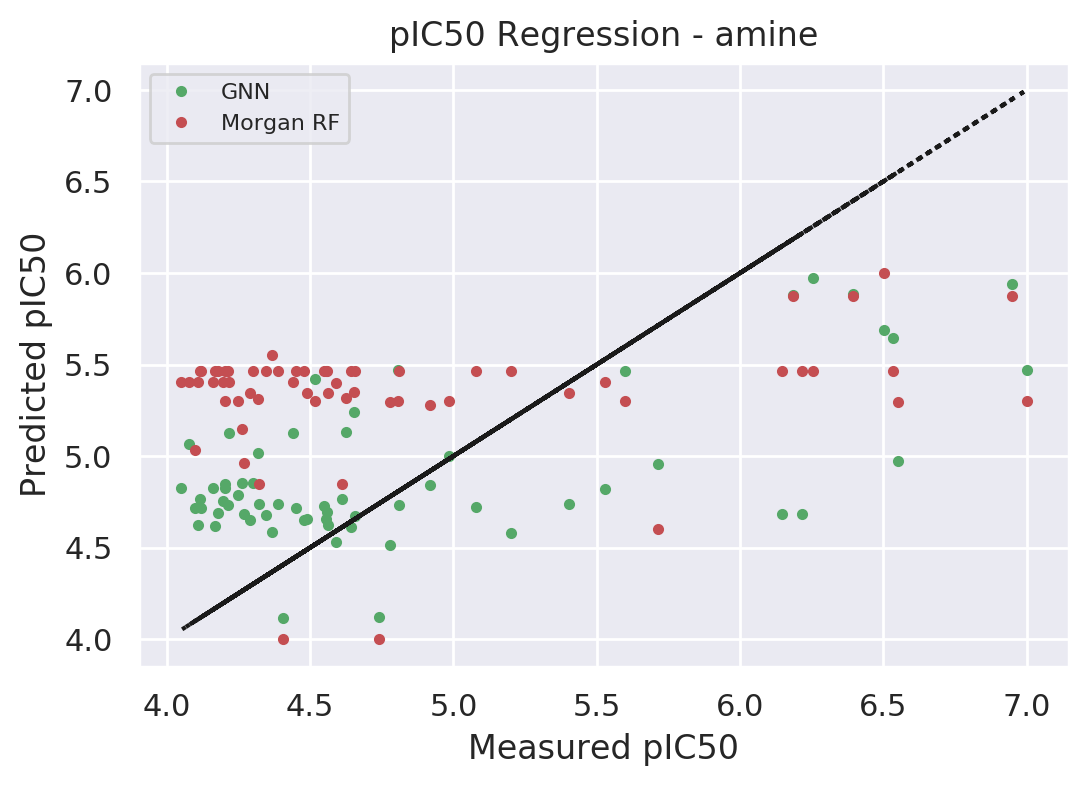

RF MPNN FPs:
roc: 0.700
prc: 0.732
GP MPNN FPs:
roc: 0.700
prc: 0.732
RF Morgan FPs:
roc: 0.613
prc: 0.395


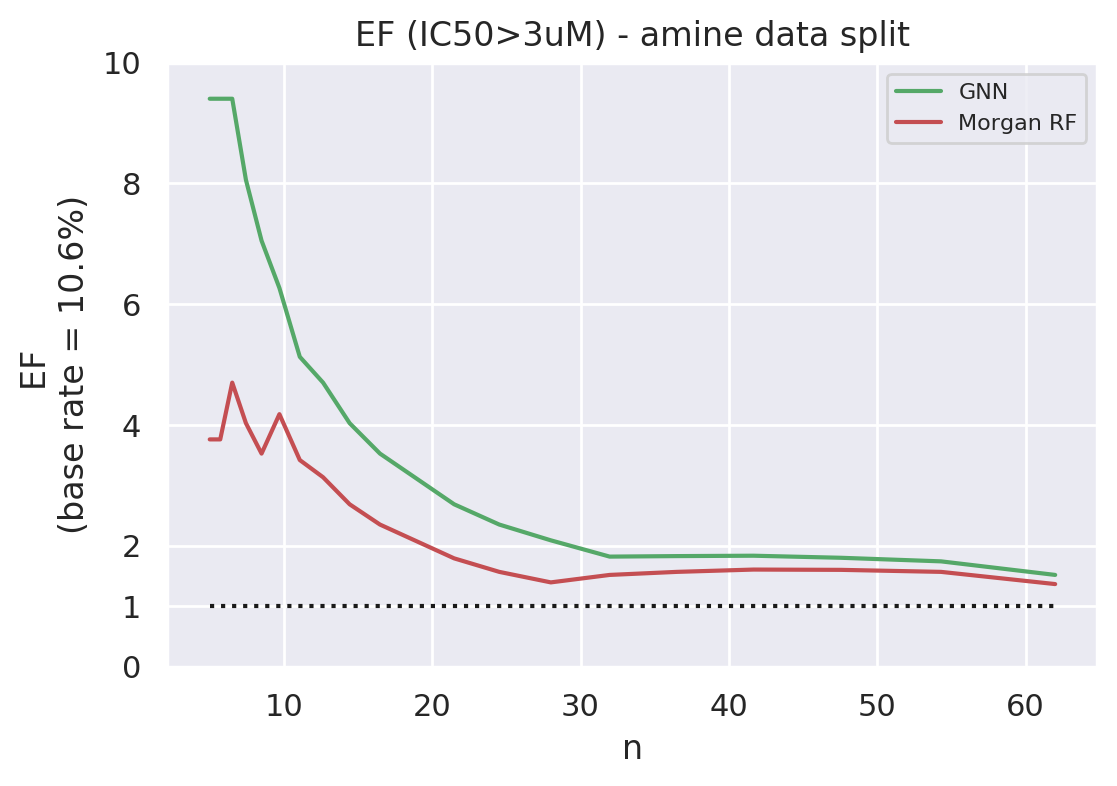

MPNN FPs:
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    9.1s


In [14]:
from sklearn.preprocessing import StandardScaler

split_names = ['acid', 'aldehyde', 'amine', 'isocyanide']

pIC50_threshold = 5.5228

reg = True
classreg = True

for i, y_test in enumerate(ys):
    y_test_class = ys_class[i]
    
    orig_prop = np.sum(y_test_class)/len(y_test_class)

    n_list = np.logspace(start=np.log10(5), stop=np.log10(min(100, len(y_test))), num=20)

    X_test_fps = xs_fp[i]
    X_test_fps_class = xs_fp_class[i]
    X_test_morgan = xs_morgan[i]
    X_test_morgan_class = xs_morgan_class[i]
    
    X_train_fps = np.concatenate([x for j,x in enumerate(xs_fp) if i!=j])
    X_train_fps_class = np.concatenate([x for j,x in enumerate(xs_fp_class) if i!=j])
    
    X_train_morgan = np.concatenate([x for j,x in enumerate(xs_morgan) if i!=j])
    X_train_morgan_class = np.concatenate([x for j,x in enumerate(xs_morgan_class) if i!=j])

    y_train = np.concatenate([y for j,y in enumerate(ys) if i!=j]).astype(int)
    y_train_class = np.concatenate([y for j,y in enumerate(ys_class) if i!=j]).astype(int)

    if reg:
        y_scaler = StandardScaler()
        y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1))
        
        print('MPNN FPs:')
        model_fps = rand_fit_forest(X_train_fps, y_train_scaled, reg=True)
        gpr_fps = GaussianProcessRegressor(kernel=RBF(1.0), random_state=0).fit(X_train_fps, y_train_scaled)
        print('Morgan FPs:')
        model_morgan = rand_fit_forest(X_train_morgan, y_train_scaled, reg=True)
   
        train_preds_fps = y_scaler.inverse_transform(model_fps.predict(X_train_fps))
        train_preds_gp = y_scaler.inverse_transform(gpr_fps.predict(X_train_fps))
        train_preds_morgan = y_scaler.inverse_transform(model_morgan.predict(X_train_morgan))

        r2_fps = r2_score(y_train,train_preds_fps)
        r2_gp = r2_score(y_train,train_preds_gp)
        r2_morgan = r2_score(y_train,train_preds_morgan)
        rmse_fps = np.sqrt(mean_squared_error(y_train, train_preds_fps))
        rmse_gp = np.sqrt(mean_squared_error(y_train, train_preds_gp))
        rmse_morgan = np.sqrt(mean_squared_error(y_train, train_preds_morgan))
        

        print('\nTraining Set (n = {}):'.format(len(y_train)))
        print("RF MPNN FPs:")
        print("R2: {:.3f}".format(r2_fps))
        print("RMSE: {:.3f}".format(rmse_fps))
        
        print("GP MPNN FPs:")
        print("R2: {:.3f}".format(r2_gp))
        print("RMSE: {:.3f}".format(rmse_gp))
        
        print("RF Morgan FPs:")
        print("R2: {:.3f}".format(r2_morgan))
        print("RMSE: {:.3f}".format(rmse_morgan))
        
        if classreg:
            train_preds_fps = y_scaler.inverse_transform(model_fps.predict(X_train_fps_class))
            train_preds_gp = y_scaler.inverse_transform(gpr_fps.predict(X_train_fps_class))
            train_preds_morgan = y_scaler.inverse_transform(model_morgan.predict(X_train_morgan_class))
            
            train_preds_fps = np.where(train_preds_fps>threshold, 1, 0)
            train_preds_gp = np.where(train_preds_gp>threshold, 1, 0)
            train_preds_morgan = np.where(train_preds_morgan>threshold, 1, 0)
            
            roc_fps = roc_auc_score(y_train_class,train_preds_fps)
            roc_gp = roc_auc_score(y_train_class,train_preds_gp)
            roc_morgan = roc_auc_score(y_train_class,train_preds_morgan)
            precision, recall, thresholds = precision_recall_curve(y_train_class, train_preds_fps)
            prc_fps = auc(recall, precision)
            precision, recall, thresholds = precision_recall_curve(y_train_class, train_preds_gp)
            prc_gp = auc(recall, precision)
            precision, recall, thresholds = precision_recall_curve(y_train_class, train_preds_morgan)
            prc_morgan = auc(recall, precision)
            
            print("RF MPNN FPs:")
            print("roc: {:.3f}".format(roc_fps))
            print("prc: {:.3f}".format(prc_fps))
            
            print("GPR MPNN FPs:")
            print("roc: {:.3f}".format(roc_gp))
            print("prc: {:.3f}".format(prc_gp))
            
            
            print("RF Morgan FPs:")
            print("roc: {:.3f}".format(roc_morgan))
            print("prc: {:.3f}".format(prc_morgan))
            
        test_preds_fps = y_scaler.inverse_transform(model_fps.predict(X_test_fps))
        test_preds_gp = y_scaler.inverse_transform(gpr_fps.predict(X_test_fps))
        test_preds_morgan = y_scaler.inverse_transform(model_morgan.predict(X_test_morgan))

        r2_fps = r2_score(y_test,test_preds_fps)
        r2_gp = r2_score(y_test,test_preds_gp)
        r2_morgan = r2_score(y_test,test_preds_morgan)
        rmse_fps = np.sqrt(mean_squared_error(y_test, test_preds_fps))
        rmse_gp = np.sqrt(mean_squared_error(y_test, test_preds_gp))
        rmse_morgan = np.sqrt(mean_squared_error(y_test, test_preds_morgan))

        print('\nTest Set ({}):'.format(split_names[i]))
        print("RF MPNN FPs:")
        print("R2: {:.3f}".format(r2_fps))
        print("RMSE: {:.3f}".format(rmse_fps))
        
        print("GP MPNN FPs:")
        print("R2: {:.3f}".format(r2_gp))
        print("RMSE: {:.3f}".format(rmse_gp))

        print("RF Morgan FPs:")
        print("R2: {:.3f}".format(r2_morgan))
        print("RMSE: {:.3f}".format(rmse_morgan))
        
        fig = plt.figure(dpi=200)
        plt.plot(y_test, test_preds_fps, 'g.', label='GNN')
        # plt.plot(y_test, test_preds_gp, 'g.', label='MPNN FP GP')
        plt.plot(y_test, test_preds_morgan,'r.', label='Morgan RF')
        plt.title('pIC50 Regression - {}'.format(split_names[i]))
        plt.legend(prop={'size': 8})
        plt.plot(y_test, y_test, 'k:')
        plt.xlabel('Measured pIC50')
        plt.ylabel('Predicted pIC50')
        plt.show()
        
        
        if classreg:
            test_preds_fps = y_scaler.inverse_transform(model_fps.predict(X_test_fps_class))
            test_preds_gp = y_scaler.inverse_transform(gpr_fps.predict(X_test_fps_class)).flatten()
            test_preds_morgan = y_scaler.inverse_transform(model_morgan.predict(X_test_morgan_class))
            
            test_preds_fps = np.where(test_preds_fps>pIC50_threshold, 1, 0)
            test_preds_gp = np.where(test_preds_gp>pIC50_threshold, 1, 0)
            test_preds_morgan = np.where(test_preds_morgan>pIC50_threshold, 1, 0)
            
            roc_fps = roc_auc_score(y_test_class,test_preds_fps)
            roc_gp = roc_auc_score(y_test_class,test_preds_gp)
            roc_morgan = roc_auc_score(y_test_class,test_preds_morgan)
            precision, recall, thresholds = precision_recall_curve(y_test_class, test_preds_fps)
            prc_fps = auc(recall, precision)
            precision, recall, thresholds = precision_recall_curve(y_test_class, test_preds_gp)
            prc_gp = auc(recall, precision)
            precision, recall, thresholds = precision_recall_curve(y_test_class, test_preds_morgan)
            prc_morgan = auc(recall, precision)
            
            print("RF MPNN FPs:")
            print("roc: {:.3f}".format(roc_fps))
            print("prc: {:.3f}".format(prc_fps))
           
            print("GP MPNN FPs:")
            print("roc: {:.3f}".format(roc_gp))
            print("prc: {:.3f}".format(prc_gp))
            
            print("RF Morgan FPs:")
            print("roc: {:.3f}".format(roc_morgan))
            print("prc: {:.3f}".format(prc_morgan))
            
            EF_fps_rf = [enrichment(test_preds_fps, y_test_class, n=int(n)) for n in n_list]
            EF_fps_gp = [enrichment(test_preds_gp, y_test_class, n=int(n)) for n in n_list]
            EF_morgan_rf = [enrichment(test_preds_morgan, y_test_class, n=int(n)) for n in n_list]
            
            fig = plt.figure(dpi=200)
            plt.plot(n_list, EF_fps_rf, 'g-', label='GNN')
            # plt.plot(n_list, EF_fps_gp, 'g-', label='MPNN FP GP')
            plt.plot(n_list, EF_morgan_rf, 'r-', label='Morgan RF')
            plt.title('EF (IC50>{}uM) - {} data split'.format(threshold, split_names[i]))
            plt.legend(prop={'size': 8})
            plt.plot(n_list, np.ones_like(n_list), 'k:')
            extraticks = [1]
            plt.yticks(list(plt.yticks()[0]) + extraticks)
            plt.ylim(bottom=0)
            plt.xlabel('n')
            plt.ylabel('EF \n(base rate = {:.1f}%)'.format(orig_prop*100))
            plt.show()
        
        
    else:
        print('MPNN FPs:')
        model_fps = rand_fit_forest(X_train_fps, y_train, reg=False)
        print('Morgan FPs:')
        model_morgan = rand_fit_forest(X_train_morgan, y_train, reg=False)
        
        train_preds_fps = model_fps.predict_proba(X_train_fps)[:,1]
        train_preds_morgan = model_morgan.predict_proba(X_train_morgan)[:,1]

        roc_fps = roc_auc_score(y_train,train_preds_fps)
        roc_morgan = roc_auc_score(y_train,train_preds_morgan)
        precision, recall, thresholds = precision_recall_curve(y_train, train_preds_fps)
        prc_fps = auc(recall, precision)
        precision, recall, thresholds = precision_recall_curve(y_train, train_preds_morgan)
        prc_morgan = auc(recall, precision)

        print('\nTraining Set (n = {}):'.format(len(y_train)))
        print("RF MPNN FPs:")
        print("roc: {:.3f}".format(roc_fps))
        print("prc: {:.3f}".format(prc_fps))
        print("RF Morgan FPs:")
        print("roc: {:.3f}".format(roc_morgan))
        print("prc: {:.3f}".format(prc_morgan))

        test_preds_fps = model_fps.predict_proba(X_test_fps)[:,1]
        test_preds_morgan = model_morgan.predict_proba(X_test_morgan)[:,1]

        EF_fps_rf = [enrichment(test_preds_fps, y_test, n=int(n)) for n in n_list]
        EF_morgan_rf = [enrichment(test_preds_morgan, y_test, n=int(n)) for n in n_list]

        y_test = y_test.astype(int)
        roc_fps = roc_auc_score(y_test,test_preds_fps)
        roc_morgan = roc_auc_score(y_test,test_preds_morgan)
        precision, recall, thresholds = precision_recall_curve(y_test, test_preds_fps)
        prc_fps = auc(recall, precision)
        precision, recall, thresholds = precision_recall_curve(y_test, test_preds_morgan)
        prc_morgan = auc(recall, precision)

        print('\nTest Set ({}):'.format(split_names[i]))
        print("RF MPNN FPs:")
        print("roc: {:.3f}".format(roc_fps))
        print("prc: {:.3f}".format(prc_fps))
        print("RF Morgan FPs:")
        print("roc: {:.3f}".format(roc_morgan))
        print("prc: {:.3f}".format(prc_morgan))

        fig = plt.figure(dpi=200)
        plt.plot(n_list, EF_fps_rf, 'g', label='GNN')
        plt.plot(n_list, EF_morgan_rf, 'r-', label='Morgan RF')
        plt.title('EF - {}'.format(split_names[i]))
        plt.legend(prop={'size': 8})
        plt.plot(n_list, np.ones_like(n_list), 'k:')
        extraticks = [1]
        plt.yticks(list(plt.yticks()[0]) + extraticks)
        plt.ylim(bottom=0)
        plt.xlabel('n')
        plt.ylabel('EF \n(base rate = {:.1f}%)'.format(orig_prop*100))
        plt.show()

including error bars

In [ ]:
split_names = ['acid', 'aldehyde', 'amine', 'isocyanide']

for i, y_test in enumerate(ys):
    print('\nTraining (n = {}) and testing on {}:'.format(len(y_train), split_names[i]))
    EFs_mpnn = []
    EFs_morgan = []
    for N in range(10):
        orig_prop = np.sum(y_test)/len(y_test)

#         n_list = np.logspace(start=np.log10(5), stop=np.log10(min(100, len(y_test))), num=20)
        n_list = np.linspace(start=5, stop=min(100, len(y_test)), num=30)

        X_test_fps = xs_fp[i]
        X_test_morgan_np = [fp_to_numpy(x) for x in xs_morgan[i]]
        X_test_morgan = [x for x in xs_morgan[i]]

        X_train_fps = np.concatenate([x for j,x in enumerate(xs_fp) if i!=j])
        X_train_morgan_np = np.concatenate([x for j,x in enumerate(xs_morgan) if i!=j])
    #     print(X_train_morgan_np)
        X_train_morgan = np.concatenate([x for j,x in enumerate(xs_morgan) if i!=j])

        y_train = np.concatenate([y for j,y in enumerate(ys) if i!=j]).astype(int)

        model_fps = fit_forest(X_train_fps, y_train)
        model_morgan = fit_forest(X_train_morgan_np, y_train)

        train_preds_fps = model_fps.predict(X_train_fps)
        train_preds_morgan = model_morgan.predict(X_train_morgan_np)

        roc_fps = roc_auc_score(y_train,train_preds_fps)
        roc_morgan = roc_auc_score(y_train,train_preds_morgan)
        precision, recall, thresholds = precision_recall_curve(y_train, train_preds_fps)
        prc_fps = auc(recall, precision)
        precision, recall, thresholds = precision_recall_curve(y_train, train_preds_morgan)
        prc_morgan = auc(recall, precision)

        test_preds_fps = model_fps.predict_proba(X_test_fps)[:,1]
        test_preds_morgan = model_morgan.predict_proba(X_test_morgan_np)[:,1]

        EF_fps_rf = [enrichment(test_preds_fps, y_test, n=int(n)) for n in n_list]
        EFs_mpnn.append(EF_fps_rf)
        EF_morgan_rf = [enrichment(test_preds_morgan, y_test, n=int(n)) for n in n_list]
        EFs_morgan.append(EF_morgan_rf)

        y_test = y_test.astype(int)
        roc_fps = roc_auc_score(y_test,test_preds_fps)
        roc_morgan = roc_auc_score(y_test,test_preds_morgan)
        precision, recall, thresholds = precision_recall_curve(y_test, test_preds_fps)
        prc_fps = auc(recall, precision)
        precision, recall, thresholds = precision_recall_curve(y_test, test_preds_morgan)
        prc_morgan = auc(recall, precision)
        
    fig = plt.figure(dpi=200)
    plt.errorbar(n_list, np.mean(EFs_mpnn, axis=0), yerr=np.std(EFs_mpnn, axis=0), fmt='b-', label='MPNN FP RF')
    plt.errorbar(n_list, np.mean(EFs_morgan, axis=0), yerr=np.std(EFs_morgan, axis=0), fmt='r-', label='Morgan RF')
    plt.title('EF - {}'.format(split_names[i]))
    plt.legend(prop={'size': 8})
    plt.plot(n_list, np.ones_like(n_list), 'k:')
    extraticks = [1]
    plt.yticks(list(plt.yticks()[0]) + extraticks)
    plt.ylim(bottom=0)
    plt.xlabel('n')
    plt.ylabel('EF \n(base rate = {:.1f}%)'.format(orig_prop*100))
    plt.show()

In [ ]:
fig = plt.figure(dpi=200)
plt.errorbar(n_list, np.mean(EFs_mpnn, axis=0), yerr=np.std(EFs_mpnn, axis=0), fmt='b-', label='MPNN FP RF')
plt.errorbar(n_list, np.mean(EFs_morgan, axis=0), yerr=np.std(EFs_morgan, axis=0), fmt='r-', label='Morgan RF')
plt.title('EF - {}'.format(split_names[i]))
plt.legend(prop={'size': 8})
plt.plot(n_list, np.ones_like(n_list), 'k:')
extraticks = [1]
plt.yticks(list(plt.yticks()[0]) + extraticks)
plt.ylim(bottom=0)
plt.xlabel('n')
plt.ylabel('EF \n(base rate = {:.1f}%)'.format(orig_prop*100))
plt.show()

In [9]:
import pandas as pd
import numpy as np
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE

X_test = np.load('ugi_docked.npy')
y_test = pd.read_csv('../docked/ugis_processed.csv')['dock_score'].to_numpy()

### Full screen

In [16]:
split_names = ['acid', 'aldehyde', 'amine', 'isocyanide']

X_train_fps = np.concatenate([x for x in xs_fp])
y_train = np.concatenate([y for y in ys]).astype(int)

orig_prop = np.sum(y_train)/len(y_train)

print('MPNN FPs:')
model_fps = grid_fit_forest(X_train_fps, y_train)
print(model_fps.classes_)

train_preds_fps = model_fps.predict_proba(X_train_fps)[:,1]

roc_fps = roc_auc_score(y_train,train_preds_fps)
precision, recall, thresholds = precision_recall_curve(y_train, train_preds_fps)
prc_fps = auc(recall, precision)

print('\nTraining Set (n = {}):'.format(len(y_train)))
print("RF MPNN FPs:")
print("roc: {:.3f}".format(roc_fps))
print("prc: {:.3f}".format(prc_fps))

# test_preds_fps = model_fps.predict_proba(X_test)[:,1]

MPNN FPs:
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 301 tasks      | elapsed:   59.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.4min finished


{'n_estimators': 1666, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 90}
[0 1]

Training Set (n = 319):
RF MPNN FPs:
roc: 0.999
prc: 0.993


In [19]:
N=100

for ind in inds:
    print(y_train[ind], train_preds_fps[ind])
# inds = np.argpartition(train_preds_fps, -N)[-N:]
# print()

0 0.05180786600354431
0 0.05246098439375754
0 0.05273395072314643
0 0.053768650317269795
0 0.0544489224261133
0 0.05500771737266336
0 0.05536786143028646
0 0.06317098267878583
0 0.06180758017492712
0 0.06463871262790831
0 0.06295232378665754
0 0.057990338992739976
0 0.05615817755673706
0 0.06300305836620367
0 0.06775138626879325
1 0.9617604184530951
1 0.4642549877093688
0 0.4642549877093688
1 0.8770865489052744
1 0.5287529297433258
1 0.427348082089979
0 0.0883367632767393
0 0.08364560109758194
0 0.12079831932773101
1 0.9440833476247634
1 0.9691655233521979
0 0.06824015320413884
1 0.9987109129366032
1 0.6571657234322291
0 0.11561767564168518
1 0.9548269307723087
1 0.556306808437661
1 0.9987109129366032
1 0.9548269307723087
0 0.07106842737094841
0 0.0745012290630538
1 0.8348668038644024
1 0.719845080889499
1 0.8809052192305491
1 0.6579546104155941
1 0.9617604184530951
1 0.8770865489052744
0 0.08433373349339739
0 0.16870819756474015
1 0.9440833476247634
1 0.6341965357571595
1 0.9691655233

In [45]:
N=1000
inds = np.argpartition(test_preds_fps, -N)[-N:]
sorted_inds = inds[np.argsort(test_preds_fps[inds])[::-1]]
print(test_preds_fps[sorted_inds])

[0.92763891 0.77725304 0.76448103 0.75357572 0.71108562 0.70778335
 0.68616089 0.65597167 0.65132458 0.51535781 0.50661836 0.50228758
 0.49659983 0.48908683 0.48512143 0.47088931 0.46811201 0.46174565
 0.45059286 0.44641071 0.44356028 0.44319228 0.433683   0.43254064
 0.43250991 0.42858524 0.42612474 0.42424255 0.42359753 0.42041841
 0.4181656  0.41793122 0.41770184 0.41514868 0.41284728 0.4069816
 0.40321891 0.40307266 0.40007193 0.39992044 0.39935141 0.39827979
 0.39694068 0.39693735 0.39620038 0.39616394 0.39498561 0.39218187
 0.39134154 0.39108096 0.39053836 0.39022204 0.39006055 0.38977305
 0.38903919 0.38831699 0.38802521 0.38760123 0.38660536 0.38599106
 0.385473   0.38516192 0.38465696 0.38345457 0.38344147 0.38335715
 0.380602   0.38010418 0.3794937  0.37899517 0.37898612 0.37863098
 0.37854689 0.37809028 0.37735451 0.3771723  0.37689361 0.37673879
 0.37632839 0.37620024 0.37598373 0.37590179 0.37573601 0.37560667
 0.37532942 0.37469393 0.37438047 0.3732836  0.37298943 0.37292

In [47]:
from tqdm import tqdm 

for ind in tqdm(sorted_inds):
    for smi in df_train['SMILES'].values:
        if MolToSmiles(MolFromSmiles(smi)) == MolToSmiles(MolFromSmiles(ugi_smiles.iloc[ind])):
            print(smi)


  0%|          | 0/1000 [00:00<?, ?it/s]

CC(C)(C)c1ccc(cc1)N(C(C(=O)NCCc1cccc(F)c1)c1cccnc1)C(=O)c1cscn1


  0%|          | 4/1000 [00:01<05:01,  3.30it/s]

CC(C)(C)c1ccc(cc1)N(C(C(=O)NCCc1cccc(F)c1)c1cccnc1)C(=O)c1ccno1


100%|██████████| 1000/1000 [04:17<00:00,  3.89it/s]


In [ ]:
ugi_smiles = pd.read_csv('../docked/ugis_processed.csv')['smiles']

In [34]:
print(np.intersect1d(df1['SMILES'],ugi_smiles))
print(np.intersect1d(df2['SMILES'],ugi_smiles))
print(np.intersect1d(df3['SMILES'],ugi_smiles))
print(np.intersect1d(df4['SMILES'],ugi_smiles))

[]
[]
[]
[]


In [ ]:
N=10

import mols2grid

inds = np.argpartition(test_preds_fps, -N)[-N:]
sorted_inds = inds[np.argsort(test_preds_fps[inds])[::-1]]

df_subset = pd.read_csv('../docked/ugis_processed.csv')['smiles'].iloc[sorted_inds]
df_subset.to_csv('topN.csv', index=False)

df_subset = df_subset.to_frame()
df_subset = df_subset.rename(columns={'smiles' : 'SMILES'})
mols2grid.display(df_subset, template="pages", n_rows=10, n_cols=5, subset=["img"], tooltip=['SMILES'])

In [ ]:
pca = PCA(n_components=2)
pca.fit(X)
print(pca.explained_variance_ratio_)

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
%matplotlib inline

In [ ]:
X = TSNE(n_components=2).fit_transform(X)

In [ ]:
plt.plot(X[:,0], X[:,1], c=y, cmap=plt.cm.Spectral)
fig.colorbar(y)